# RNN and LSTM on time series

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 8ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 194.7819 - mae: 195.2819
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 193.5109 - mae: 194.0109
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 191.9080 - mae: 192.4080
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 187.8582 - mae: 188.3582
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 185.3786 - mae: 185.8786
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 182.5483 - mae: 183.0483
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [=====================

8/8 [==============================] - 0s 5ms/step - loss: 15.9252 - mae: 16.4218
Epoch 88/100
8/8 [==============================] - 0s 5ms/step - loss: 27.9045 - mae: 28.4006
Epoch 89/100
8/8 [==============================] - 0s 5ms/step - loss: 29.2215 - mae: 29.7185
Epoch 90/100
8/8 [==============================] - 0s 6ms/step - loss: 21.9373 - mae: 22.4319
Epoch 91/100
8/8 [==============================] - 0s 5ms/step - loss: 35.0932 - mae: 35.5910
Epoch 92/100
8/8 [==============================] - 0s 6ms/step - loss: 37.5076 - mae: 38.0058
Epoch 93/100
8/8 [==============================] - 0s 6ms/step - loss: 19.6282 - mae: 20.1241
Epoch 94/100
8/8 [==============================] - 0s 5ms/step - loss: 29.3288 - mae: 29.8265
Epoch 95/100
8/8 [==============================] - 0s 5ms/step - loss: 47.3511 - mae: 47.8500
Epoch 96/100
8/8 [==============================] - 0s 6ms/step - loss: 58.5777 - mae: 59.0761
Epoch 97/100
8/8 [==============================] - 0s 6ms/step

(1e-08, 0.0001, 0.0, 30.0)

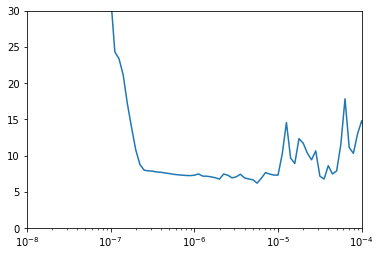

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 6ms/step - loss: 81.7535 - mae: 82.2534
Epoch 2/400
8/8 [==============================] - 0s 5ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 5ms/step - loss: 15.9200 - mae: 16.4144
Epoch 4/400
8/8 [==============================] - 0s 6ms/step - loss: 12.2878 - mae: 12.7813
Epoch 5/400
8/8 [==============================] - 0s 6ms/step - loss: 10.1492 - mae: 10.6394
Epoch 6/400
8/8 [==============================] - 0s 6ms/step - loss: 16.4058 - mae: 16.9008
Epoch 7/400
8/8 [==============================] - 0s 6ms/step - loss: 13.2711 - mae: 13.7631
Epoch 8/400
8/8 [==============================] - 0s 6ms/step - loss: 9.2175 - mae: 9.7060
Epoch 9/400
8/8 [==============================] - 0s 6ms/step - loss: 8.3240 - mae: 8.8145
Epoch 10/400
8/8 [==============================] - 0s 6ms/step - loss: 7.2584 - mae: 7.7412
Epoch 11/400
8/8 [==============================] - 0s 5ms/step -

8/8 [==============================] - 0s 5ms/step - loss: 9.4911 - mae: 9.9803
Epoch 89/400
8/8 [==============================] - 0s 6ms/step - loss: 7.5178 - mae: 8.0071
Epoch 90/400
8/8 [==============================] - 0s 6ms/step - loss: 6.5977 - mae: 7.0845
Epoch 91/400
8/8 [==============================] - 0s 6ms/step - loss: 5.1425 - mae: 5.6212
Epoch 92/400
8/8 [==============================] - 0s 5ms/step - loss: 4.8787 - mae: 5.3536
Epoch 93/400
8/8 [==============================] - 0s 6ms/step - loss: 5.2842 - mae: 5.7617
Epoch 94/400
8/8 [==============================] - 0s 6ms/step - loss: 5.3186 - mae: 5.7993
Epoch 95/400
8/8 [==============================] - 0s 6ms/step - loss: 4.4340 - mae: 4.9129
Epoch 96/400
8/8 [==============================] - 0s 5ms/step - loss: 4.6046 - mae: 5.0835
Epoch 97/400
8/8 [==============================] - 0s 5ms/step - loss: 5.1791 - mae: 5.6600
Epoch 98/400
8/8 [==============================] - 0s 5ms/step - loss: 6.5851 - ma

8/8 [==============================] - 0s 5ms/step - loss: 4.8688 - mae: 5.3465
Epoch 176/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6073 - mae: 5.0838
Epoch 177/400
8/8 [==============================] - 0s 6ms/step - loss: 4.1311 - mae: 4.6057
Epoch 178/400
8/8 [==============================] - 0s 6ms/step - loss: 4.7496 - mae: 5.2270
Epoch 179/400
8/8 [==============================] - 0s 6ms/step - loss: 5.7544 - mae: 6.2355
Epoch 180/400
8/8 [==============================] - 0s 5ms/step - loss: 5.3096 - mae: 5.7902
Epoch 181/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3661 - mae: 4.8458
Epoch 182/400
8/8 [==============================] - 0s 5ms/step - loss: 4.3195 - mae: 4.7942
Epoch 183/400
8/8 [==============================] - 0s 5ms/step - loss: 5.0457 - mae: 5.5262
Epoch 184/400
8/8 [==============================] - 0s 5ms/step - loss: 5.5094 - mae: 5.9932
Epoch 185/400
8/8 [==============================] - 0s 5ms/step - loss: 5

8/8 [==============================] - 0s 5ms/step - loss: 4.9826 - mae: 5.4613
Epoch 263/400
8/8 [==============================] - 0s 5ms/step - loss: 4.8188 - mae: 5.2971
Epoch 264/400
8/8 [==============================] - 0s 5ms/step - loss: 5.3912 - mae: 5.8713
Epoch 265/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6306 - mae: 5.1086
Epoch 266/400
8/8 [==============================] - 0s 6ms/step - loss: 4.4047 - mae: 4.8803
Epoch 267/400
8/8 [==============================] - 0s 5ms/step - loss: 4.1442 - mae: 4.6204
Epoch 268/400
8/8 [==============================] - 0s 5ms/step - loss: 4.7743 - mae: 5.2516
Epoch 269/400
8/8 [==============================] - 0s 6ms/step - loss: 4.3348 - mae: 4.8084
Epoch 270/400
8/8 [==============================] - 0s 6ms/step - loss: 4.1944 - mae: 4.6660
Epoch 271/400
8/8 [==============================] - 0s 5ms/step - loss: 4.8234 - mae: 5.2991
Epoch 272/400
8/8 [==============================] - 0s 6ms/step - loss: 5

8/8 [==============================] - 0s 5ms/step - loss: 6.8430 - mae: 7.3293
Epoch 350/400
8/8 [==============================] - 0s 6ms/step - loss: 4.6567 - mae: 5.1369
Epoch 351/400
8/8 [==============================] - 0s 6ms/step - loss: 4.2898 - mae: 4.7699
Epoch 352/400
8/8 [==============================] - 0s 5ms/step - loss: 4.3051 - mae: 4.7825
Epoch 353/400
8/8 [==============================] - 0s 5ms/step - loss: 4.1939 - mae: 4.6700
Epoch 354/400
8/8 [==============================] - 0s 5ms/step - loss: 4.8790 - mae: 5.3547
Epoch 355/400
8/8 [==============================] - 0s 5ms/step - loss: 6.7235 - mae: 7.2134
Epoch 356/400
8/8 [==============================] - 0s 5ms/step - loss: 6.0880 - mae: 6.5714
Epoch 357/400
8/8 [==============================] - 0s 5ms/step - loss: 6.0438 - mae: 6.5277
Epoch 358/400
8/8 [==============================] - 0s 5ms/step - loss: 5.3396 - mae: 5.8147
Epoch 359/400
8/8 [==============================] - 0s 5ms/step - loss: 5

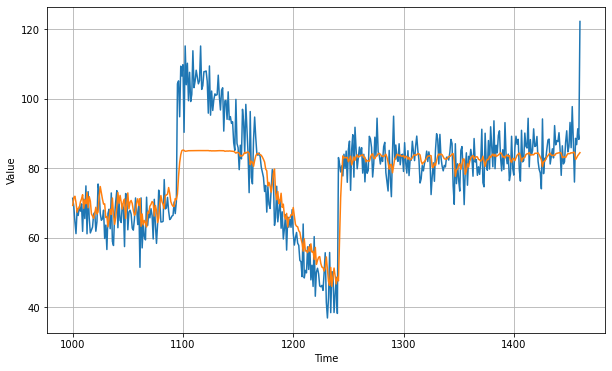

In [7]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.3576536

<Figure size 432x288 with 0 Axes>

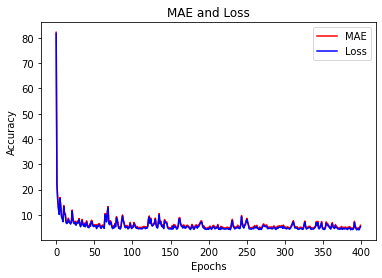

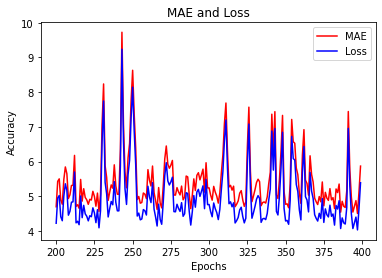

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 3s 14ms/step - loss: 21.5167 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 0s 14ms/step - loss: 21.1522 - mae: 21.6444
Epoch 3/100
31/31 [==============================] - 0s 14ms/step - loss: 20.7302 - mae: 21.2236
Epoch 4/100
31/31 [==============================] - 0s 14ms/step - loss: 20.2834 - mae: 20.7757
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 19.7897 - mae: 20.2855
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 19.1782 - mae: 19.6696
Epoch 7/100
31/31 [==============================] - 0s 14ms/step - loss: 18.2410 - mae: 18.7333
Epoch 8/100
31/31 [==============================] - 0s 14ms/step - loss: 17.4825 - mae: 17.9748
Epoch 9/100
31/31 [==============================] - 0s 14ms/step - loss: 17.1597 - mae: 17.6529
Epoch 10/100
31/31 [==============================] - 0s 14ms/step - loss: 16.8547 - mae: 17.3463
Epoch 11/100
31/31 [=========

31/31 [==============================] - 0s 14ms/step - loss: 5.9594 - mae: 6.4422
Epoch 86/100
31/31 [==============================] - 0s 14ms/step - loss: 5.5533 - mae: 6.0356
Epoch 87/100
31/31 [==============================] - 0s 14ms/step - loss: 7.5450 - mae: 8.0311
Epoch 88/100
31/31 [==============================] - 0s 14ms/step - loss: 10.0101 - mae: 10.4985
Epoch 89/100
31/31 [==============================] - 0s 14ms/step - loss: 9.2173 - mae: 9.7066
Epoch 90/100
31/31 [==============================] - 0s 14ms/step - loss: 7.9573 - mae: 8.4421
Epoch 91/100
31/31 [==============================] - 0s 14ms/step - loss: 6.9050 - mae: 7.3899
Epoch 92/100
31/31 [==============================] - 0s 14ms/step - loss: 7.7353 - mae: 8.2190
Epoch 93/100
31/31 [==============================] - 0s 14ms/step - loss: 13.1869 - mae: 13.6787
Epoch 94/100
31/31 [==============================] - 0s 14ms/step - loss: 10.4972 - mae: 10.9863
Epoch 95/100
31/31 [===========================

(1e-08, 0.0001, 0.0, 30.0)

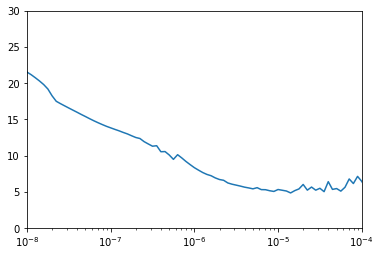

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
31/31 [==============================] - 3s 14ms/step - loss: 774.4835 - mae: 21.3908
Epoch 2/500
31/31 [==============================] - 0s 14ms/step - loss: 121.7237 - mae: 8.3301
Epoch 3/500
31/31 [==============================] - 0s 14ms/step - loss: 133.4667 - mae: 8.9035
Epoch 4/500
31/31 [==============================] - 0s 14ms/step - loss: 195.3525 - mae: 10.5144
Epoch 5/500
31/31 [==============================] - 0s 14ms/step - loss: 169.1231 - mae: 9.8495
Epoch 6/500
31/31 [==============================] - 0s 14ms/step - loss: 219.3307 - mae: 11.9332
Epoch 7/500
31/31 [==============================] - 0s 14ms/step - loss: 153.2345 - mae: 9.6756
Epoch 8/500
31/31 [==============================] - 0s 14ms/step - loss: 89.6451 - mae: 7.1743
Epoch 9/500
31/31 [==============================] - 0s 14ms/step - loss: 79.8224 - mae: 6.7707
Epoch 10/500
31/31 [==============================] - 0s 14ms/step - loss: 81.5774 - mae: 6.9775
Epoch 11/500
31/31 [=========

31/31 [==============================] - 0s 14ms/step - loss: 52.9188 - mae: 5.4968
Epoch 86/500
31/31 [==============================] - 0s 14ms/step - loss: 43.7319 - mae: 4.9334
Epoch 87/500
31/31 [==============================] - 0s 14ms/step - loss: 56.7777 - mae: 5.7309
Epoch 88/500
31/31 [==============================] - 0s 14ms/step - loss: 49.7444 - mae: 5.3464
Epoch 89/500
31/31 [==============================] - 0s 14ms/step - loss: 46.1289 - mae: 5.1878
Epoch 90/500
31/31 [==============================] - 0s 14ms/step - loss: 48.3201 - mae: 5.2536
Epoch 91/500
31/31 [==============================] - 0s 14ms/step - loss: 58.9185 - mae: 5.9838
Epoch 92/500
31/31 [==============================] - 0s 14ms/step - loss: 50.6545 - mae: 5.4284
Epoch 93/500
31/31 [==============================] - 0s 14ms/step - loss: 47.7519 - mae: 5.2322
Epoch 94/500
31/31 [==============================] - 0s 14ms/step - loss: 47.2115 - mae: 5.1649
Epoch 95/500
31/31 [=======================

31/31 [==============================] - 0s 14ms/step - loss: 43.2620 - mae: 5.0150
Epoch 169/500
31/31 [==============================] - 0s 14ms/step - loss: 54.0432 - mae: 5.6880
Epoch 170/500
31/31 [==============================] - 0s 14ms/step - loss: 44.0429 - mae: 5.0779
Epoch 171/500
31/31 [==============================] - 0s 14ms/step - loss: 40.6143 - mae: 4.7871
Epoch 172/500
31/31 [==============================] - 0s 14ms/step - loss: 45.9713 - mae: 5.1048
Epoch 173/500
31/31 [==============================] - 0s 14ms/step - loss: 42.4350 - mae: 4.9323
Epoch 174/500
31/31 [==============================] - 0s 14ms/step - loss: 49.2674 - mae: 5.3140
Epoch 175/500
31/31 [==============================] - 0s 14ms/step - loss: 42.7176 - mae: 4.9472
Epoch 176/500
31/31 [==============================] - 0s 14ms/step - loss: 41.7883 - mae: 4.8893
Epoch 177/500
31/31 [==============================] - 0s 14ms/step - loss: 41.8352 - mae: 4.8625
Epoch 178/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 39.0297 - mae: 4.7013
Epoch 252/500
31/31 [==============================] - 0s 14ms/step - loss: 48.0111 - mae: 5.3251
Epoch 253/500
31/31 [==============================] - 0s 14ms/step - loss: 41.8017 - mae: 4.8521
Epoch 254/500
31/31 [==============================] - 0s 14ms/step - loss: 41.5031 - mae: 4.8596
Epoch 255/500
31/31 [==============================] - 0s 14ms/step - loss: 52.6227 - mae: 5.5540
Epoch 256/500
31/31 [==============================] - 0s 14ms/step - loss: 44.0742 - mae: 5.0126
Epoch 257/500
31/31 [==============================] - 0s 14ms/step - loss: 49.0679 - mae: 5.3655
Epoch 258/500
31/31 [==============================] - 1s 15ms/step - loss: 41.8016 - mae: 4.9171
Epoch 259/500
31/31 [==============================] - 0s 14ms/step - loss: 40.6944 - mae: 4.8830
Epoch 260/500
31/31 [==============================] - 0s 14ms/step - loss: 49.1256 - mae: 5.3186
Epoch 261/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 38.1216 - mae: 4.6482
Epoch 335/500
31/31 [==============================] - 0s 14ms/step - loss: 41.0803 - mae: 4.9121
Epoch 336/500
31/31 [==============================] - 0s 14ms/step - loss: 43.8728 - mae: 5.0553
Epoch 337/500
31/31 [==============================] - 0s 14ms/step - loss: 42.4373 - mae: 4.9996
Epoch 338/500
31/31 [==============================] - 0s 14ms/step - loss: 41.8231 - mae: 4.8840
Epoch 339/500
31/31 [==============================] - 0s 14ms/step - loss: 41.8066 - mae: 4.8864
Epoch 340/500
31/31 [==============================] - 0s 14ms/step - loss: 40.4794 - mae: 4.8244
Epoch 341/500
31/31 [==============================] - 0s 14ms/step - loss: 41.5057 - mae: 4.8830
Epoch 342/500
31/31 [==============================] - 0s 14ms/step - loss: 50.1175 - mae: 5.4646
Epoch 343/500
31/31 [==============================] - 0s 14ms/step - loss: 48.3227 - mae: 5.3042
Epoch 344/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 38.3052 - mae: 4.6612
Epoch 418/500
31/31 [==============================] - 0s 14ms/step - loss: 38.4150 - mae: 4.7058
Epoch 419/500
31/31 [==============================] - 0s 14ms/step - loss: 38.6018 - mae: 4.6899
Epoch 420/500
31/31 [==============================] - 0s 14ms/step - loss: 40.2803 - mae: 4.8339
Epoch 421/500
31/31 [==============================] - 0s 14ms/step - loss: 44.6355 - mae: 5.1244
Epoch 422/500
31/31 [==============================] - 0s 14ms/step - loss: 42.9195 - mae: 5.0109
Epoch 423/500
31/31 [==============================] - 0s 14ms/step - loss: 36.8767 - mae: 4.6018
Epoch 424/500
31/31 [==============================] - 0s 14ms/step - loss: 36.8361 - mae: 4.5851
Epoch 425/500
31/31 [==============================] - 0s 14ms/step - loss: 38.7775 - mae: 4.6982
Epoch 426/500
31/31 [==============================] - 0s 14ms/step - loss: 40.8236 - mae: 4.8942
Epoch 427/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 35.3159 - mae: 4.5059


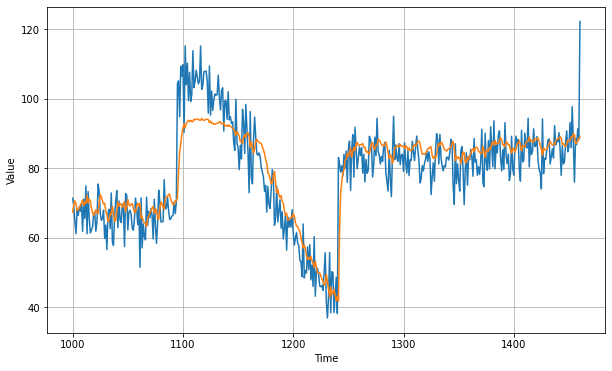

In [13]:

forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.7150693

<Figure size 432x288 with 0 Axes>

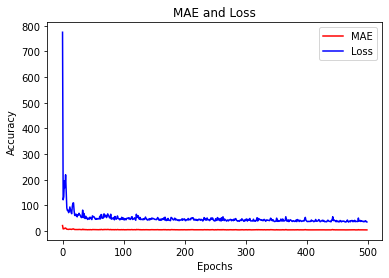

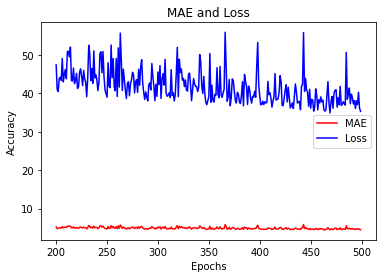

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [16]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=0)

In [17]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 5s 21ms/step - loss: 755.7013
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 152.7785
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 97.9761
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 83.2915
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 78.2600
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 73.4347
Epoch 7/100
31/31 [==============================] - 1s 21ms/step - loss: 67.8632
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 74.5354
Epoch 9/100
31/31 [==============================] - 1s 21ms/step - loss: 73.1458
Epoch 10/100
31/31 [==============================] - 1s 21ms/step - loss: 63.4809
Epoch 11/100
31/31 [==============================] - 1s 20ms/step - loss: 60.9757
Epoch 12/100
31/31 [==============================] - 1s 21ms/step - loss: 57.7044
Epoch 13/10

31/31 [==============================] - 1s 21ms/step - loss: 45.3499
Epoch 100/100
31/31 [==============================] - 1s 21ms/step - loss: 46.9555
